# 3. Model Evaluation
We evaluate models trained on features from the Hugging Face dataset `chen1028/Cl-Containing-Compound`. 

## Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_curve, auc, precision_recall_curve, confusion_matrix)
import matplotlib.pyplot as plt
import seaborn as sns

# Load and prepare data (similar to notebook 1)
repo_id = "chen1028/Cl-Containing-Compound"
ds = load_dataset("csv", data_files={"train": f"hf://datasets/{repo_id}/train.csv", "test": f"hf://datasets/{repo_id}/test.csv"})
train_df = ds["train"].to_pandas()
test_df = ds["test"].to_pandas()

def _to_binary_cl(series: pd.Series) -> pd.Series:
    s = pd.to_numeric(series, errors="coerce").fillna(0)
    return (s != 0).astype(int)

if "has_cl" not in train_df.columns and "Cl" in train_df.columns:
    train_df["has_cl"] = _to_binary_cl(train_df["Cl"])
if "has_cl" not in test_df.columns and "Cl" in test_df.columns:
    test_df["has_cl"] = _to_binary_cl(test_df["Cl"])

exclude_cols = {"has_cl", "Cl", "MF", "mode"}
feature_cols = [c for c in train_df.columns if c not in exclude_cols and train_df[c].dtype in [np.float64, np.int64]]

X_train = train_df[feature_cols]
y_train = train_df["has_cl"]
X_test = test_df[feature_cols]
y_test = test_df["has_cl"]

# Align columns
common_cols = list(set(X_train.columns) & set(X_test.columns))
X_train = X_train[common_cols]
X_test = X_test[common_cols]

# Define preprocessing and models
preprocess = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Retrain models needed for evaluation
trained_models = {
    "Logistic Regression": Pipeline([("preprocess", preprocess), ("clf", LogisticRegression(random_state=42))]),
    "Random Forest": Pipeline([("preprocess", preprocess), ("clf", RandomForestClassifier(random_state=42))])
}

for name, model in trained_models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)

print("Models are trained and ready for evaluation.")

Training Logistic Regression...
Training Random Forest...
Training Random Forest...
Models are trained and ready for evaluation.
Models are trained and ready for evaluation.


## 1. Data Setup and Model Training

Let's train several models for evaluation.

In [2]:
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier

# Train multiple models for comparison (pipelines to handle NaNs and scaling)
models = {
    'Logistic Regression': Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler(with_mean=False)),
        ("clf", LogisticRegression(random_state=42, max_iter=1000))
    ]),
    'Random Forest': Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("clf", RandomForestClassifier(n_estimators=100, random_state=42))
    ]),
    'Naive Bayes': Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("clf", GaussianNB())
    ]),
    'Random Classifier': DummyClassifier(strategy='stratified', random_state=42)  # Baseline
}

trained_models = {}
predictions = {}
probabilities = {}

print("Training models...")
for name, model in models.items():
    print(f"  Training {name}")
    model.fit(X_train, y_train)
    trained_models[name] = model
    
    # Get predictions
    y_pred = model.predict(X_test)
    predictions[name] = y_pred
    
    # Get probabilities (for ROC/PR curves)
    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X_test)[:, 1]  # Probability of positive class
        probabilities[name] = y_prob

print("\nModel training completed!")

Training models...
  Training Logistic Regression
  Training Random Forest
  Training Random Forest


  Training Naive Bayes
  Training Random Classifier

Model training completed!
  Training Random Classifier

Model training completed!


## 2. Classification Metrics

Let's calculate and understand the key classification metrics:

- **Accuracy**: Overall correctness (TP + TN) / (TP + TN + FP + FN)
- **Precision**: How many predicted positives are actually positive TP / (TP + FP)
- **Recall (Sensitivity)**: How many actual positives are correctly identified TP / (TP + FN)
- **F1-score**: Harmonic mean of precision and recall 2 * (Precision * Recall) / (Precision + Recall)

Model Performance Metrics:
              Model  Accuracy  Precision  Recall  F1-Score
Logistic Regression     1.000      0.999   1.000     1.000
      Random Forest     1.000      1.000   1.000     1.000
        Naive Bayes     0.926      0.973   0.876     0.922
  Random Classifier     0.501      0.498   0.500     0.499


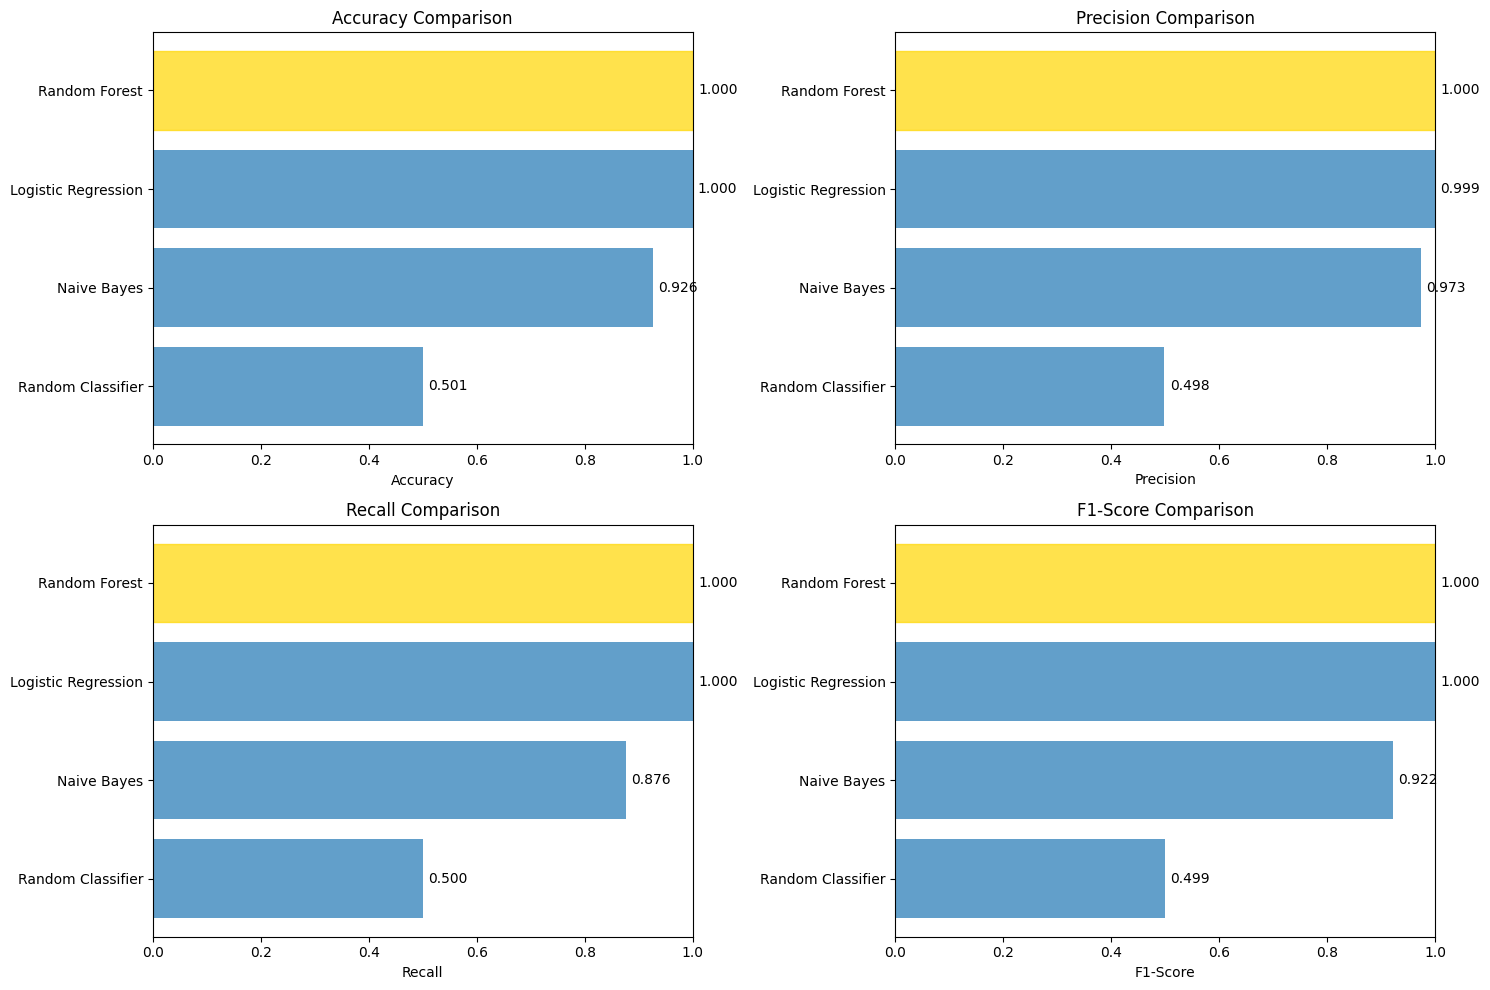

In [3]:
# Calculate metrics for all models
metrics_df = pd.DataFrame({
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': []
})

for name, y_pred in predictions.items():
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    metrics_df = pd.concat([
        metrics_df,
        pd.DataFrame({
            'Model': [name],
            'Accuracy': [accuracy],
            'Precision': [precision],
            'Recall': [recall],
            'F1-Score': [f1]
        })
    ], ignore_index=True)

# Display results
print("Model Performance Metrics:")
print("=" * 70)
print(metrics_df.round(3).to_string(index=False))

# Visualize metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i//2, i%2]
    
    # Sort models by metric value for better visualization
    sorted_data = metrics_df.sort_values(metric, ascending=True)
    
    bars = ax.barh(sorted_data['Model'], sorted_data[metric], alpha=0.7)
    ax.set_xlabel(metric)
    ax.set_title(f'{metric} Comparison')
    ax.set_xlim(0, 1)
    
    # Add value labels
    for j, (bar, value) in enumerate(zip(bars, sorted_data[metric])):
        ax.text(value + 0.01, bar.get_y() + bar.get_height()/2, 
               f'{value:.3f}', va='center')
    
    # Highlight the best performing model
    best_idx = sorted_data[metric].idxmax()
    bars[len(bars)-1].set_color('gold')

plt.tight_layout()
plt.show()

## 3. Confusion Matrix Analysis

Confusion matrices provide detailed insight into classification performance by showing the breakdown of correct and incorrect predictions for each class.

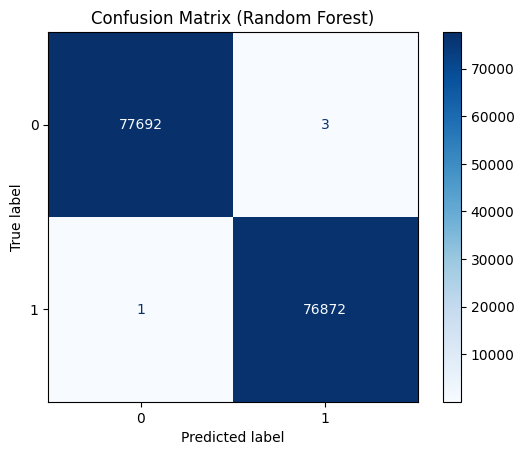

In [4]:
# Confusion Matrix using the Random Forest pipeline by default
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Choose a reference model (Random Forest if available)
ref_model_name = 'Random Forest'
if ref_model_name in trained_models:
    ref_model = trained_models[ref_model_name]
    ref_pred = predictions[ref_model_name]

    cm = confusion_matrix(y_test, ref_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ref_model.classes_)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix ({ref_model_name})')
    plt.show()
else:
    print(f'{ref_model_name} not found in trained models. Skipping confusion matrix.')

In [5]:
# Determine the best model based on F1-score
from sklearn.metrics import precision_score, recall_score

metrics_df = pd.DataFrame({
    'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1-Score': []
})
for name, y_pred in predictions.items():
    metrics_df = pd.concat([
        metrics_df,
        pd.DataFrame({
            'Model': [name],
            'Accuracy': [accuracy_score(y_test, y_pred)],
            'Precision': [precision_score(y_test, y_pred)],
            'Recall': [recall_score(y_test, y_pred)],
            'F1-Score': [f1_score(y_test, y_pred)]
        })
    ], ignore_index=True)

best_model_name = metrics_df.loc[metrics_df['F1-Score'].idxmax(), 'Model']
best_model = trained_models[best_model_name]

print(f"The best model is: {best_model_name}")

The best model is: Random Forest


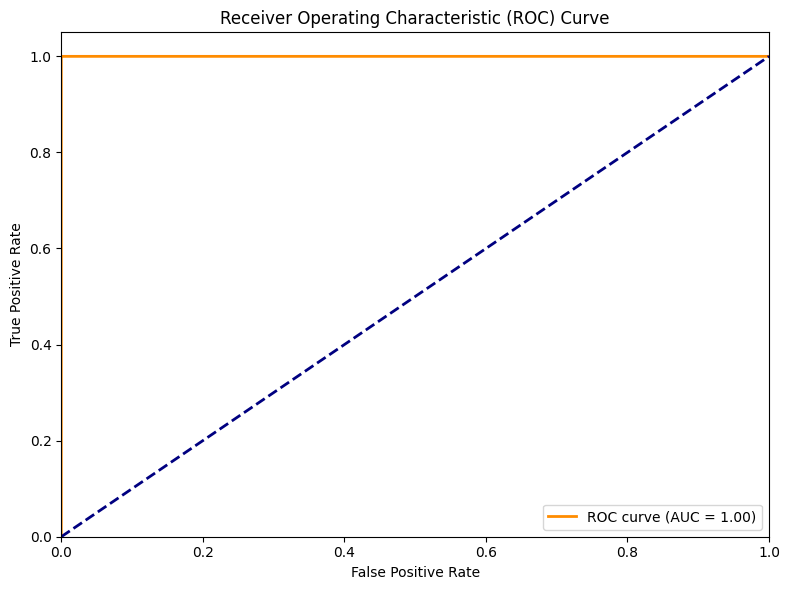

In [6]:
# Improved Model Evaluation Visualization: ROC Curve for Best Model
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Use best_model and X_test, y_test
if 'best_model' in locals() and 'X_test' in locals() and 'y_test' in locals():
    y_prob = best_model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
else:
    print('Required variables for ROC curve not found. Skipping plot.')

## 4. ROC Curves and AUC Analysis

ROC (Receiver Operating Characteristic) curves show the trade-off between True Positive Rate and False Positive Rate across different threshold values. AUC (Area Under the Curve) provides a single metric to compare models.

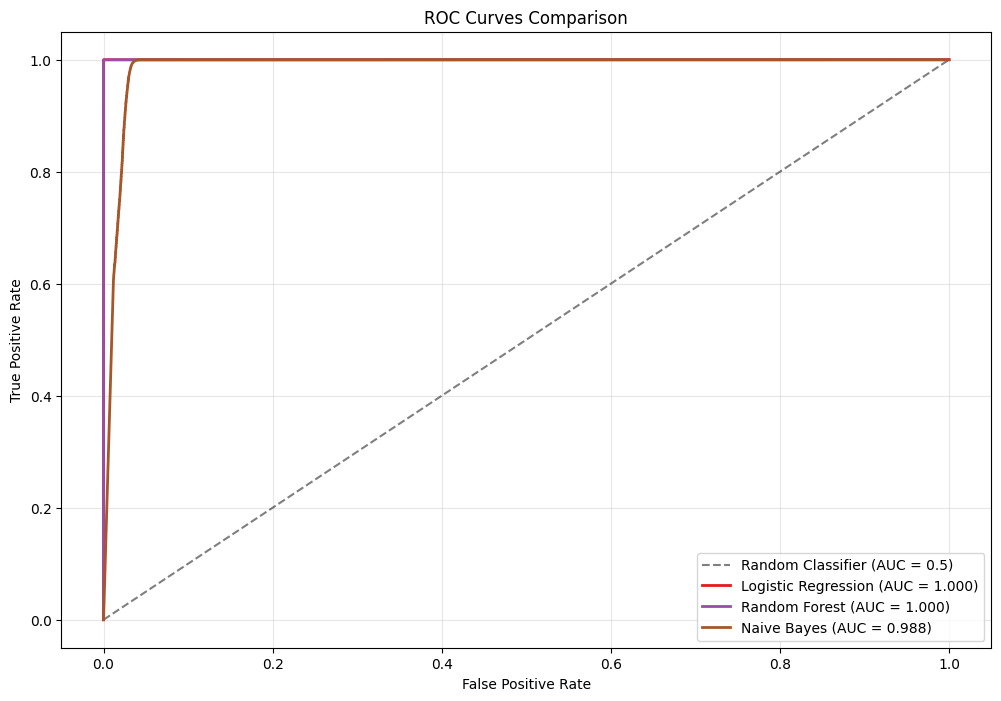

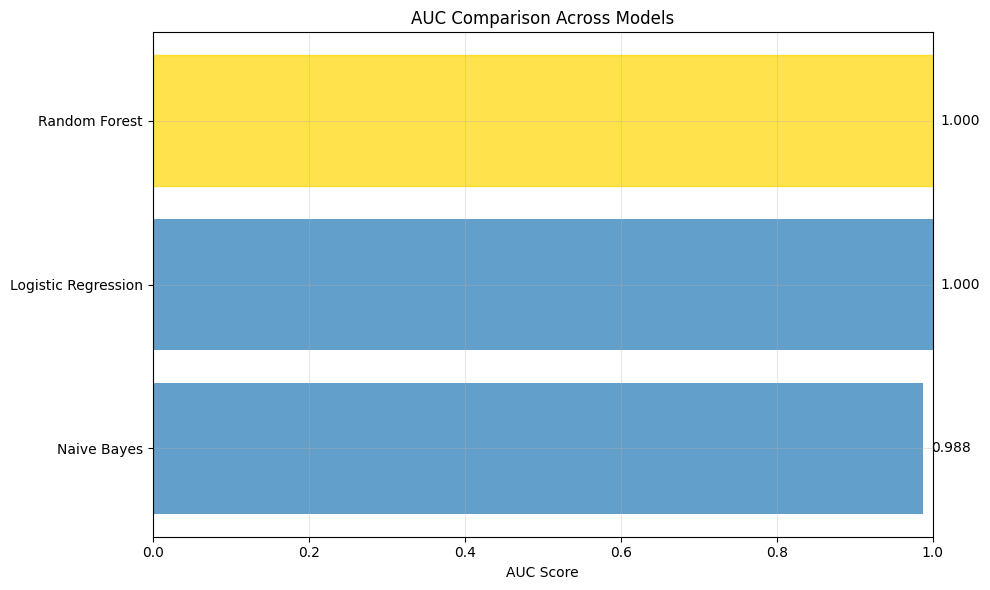

Best AUC: Random Forest (1.000)


In [7]:
from sklearn.metrics import roc_auc_score

# Plot ROC curves for all models with probabilities
plt.figure(figsize=(12, 8))

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier (AUC = 0.5)')

auc_scores = {}
colors = plt.cm.Set1(np.linspace(0, 1, len(probabilities)))

for i, (name, y_prob) in enumerate(probabilities.items()):
    if name == 'Random Classifier':  # Skip dummy classifier
        continue
        
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    auc_val = roc_auc_score(y_test, y_prob)
    auc_scores[name] = auc_val
    
    # Plot ROC curve
    plt.plot(fpr, tpr, color=colors[i], linewidth=2, 
             label=f'{name} (AUC = {auc_val:.3f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# AUC comparison
if auc_scores:
    auc_df = pd.DataFrame(list(auc_scores.items()), columns=['Model', 'AUC'])
    auc_df = auc_df.sort_values('AUC', ascending=True)

    plt.figure(figsize=(10, 6))
    bars = plt.barh(auc_df['Model'], auc_df['AUC'], alpha=0.7)
    plt.xlabel('AUC Score')
    plt.title('AUC Comparison Across Models')
    plt.xlim(0, 1)

    # Highlight the best AUC
    best_auc_idx = auc_df['AUC'].idxmax()
    bars[auc_df.index.get_loc(best_auc_idx)].set_color('gold')

    # Add value labels
    for bar, value in zip(bars, auc_df['AUC']):
        plt.text(value + 0.01, bar.get_y() + bar.get_height()/2, 
                 f'{value:.3f}', va='center')

    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"Best AUC: {auc_df.loc[best_auc_idx, 'Model']} ({auc_df.loc[best_auc_idx, 'AUC']:.3f})")
else:
    print("No models with probability estimates found to compare AUC.")

## 5. Precision-Recall Curves

For imbalanced datasets, Precision-Recall curves can be more informative than ROC curves, especially when you care more about the positive class.

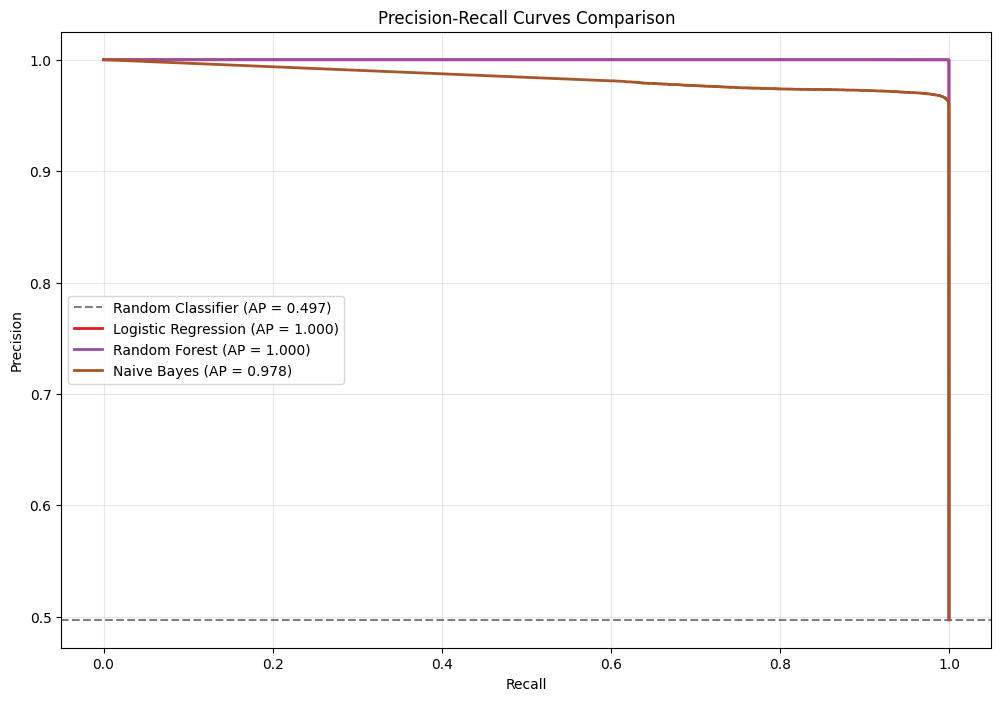

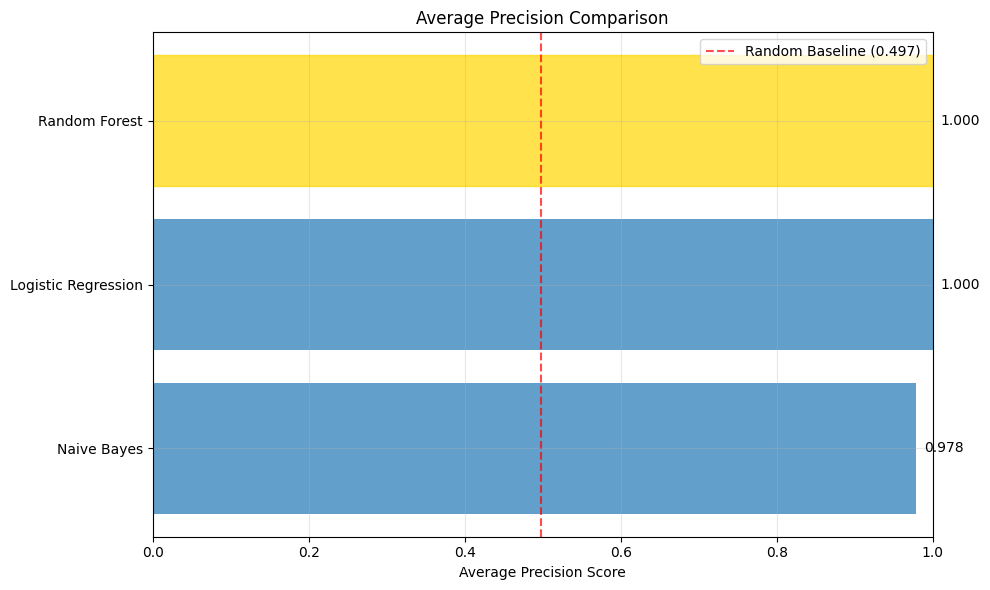

In [8]:
from sklearn.metrics import average_precision_score

# Plot Precision-Recall curves
plt.figure(figsize=(12, 8))

# Calculate baseline (random classifier performance)
baseline_precision = np.sum(y_test == 1) / len(y_test)
plt.axhline(y=baseline_precision, color='k', linestyle='--', alpha=0.5,
            label=f'Random Classifier (AP = {baseline_precision:.3f})')

ap_scores = {}

for i, (name, y_prob) in enumerate(probabilities.items()):
    if name == 'Random Classifier':  # Skip dummy classifier
        continue
        
    # Calculate Precision-Recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
    ap = average_precision_score(y_test, y_prob)
    ap_scores[name] = ap
    
    # Plot PR curve
    plt.plot(recall, precision, color=colors[i], linewidth=2,
             label=f'{name} (AP = {ap:.3f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves Comparison')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Compare Average Precision scores
if ap_scores:
    ap_df = pd.DataFrame(list(ap_scores.items()), columns=['Model', 'Average_Precision'])
    ap_df = ap_df.sort_values('Average_Precision', ascending=True)

    plt.figure(figsize=(10, 6))
    bars = plt.barh(ap_df['Model'], ap_df['Average_Precision'], alpha=0.7)
    plt.xlabel('Average Precision Score')
    plt.title('Average Precision Comparison')
    plt.xlim(0, 1)

    # Add baseline line
    plt.axvline(x=baseline_precision, color='red', linestyle='--', alpha=0.7,
                label=f'Random Baseline ({baseline_precision:.3f})')

    # Highlight the best AP
    best_ap_idx = ap_df['Average_Precision'].idxmax()
    bars[ap_df.index.get_loc(best_ap_idx)].set_color('gold')

    # Add value labels
    for bar, value in zip(bars, ap_df['Average_Precision']):
        plt.text(value + 0.01, bar.get_y() + bar.get_height()/2, 
                 f'{value:.3f}', va='center')

    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No models with probability estimates found to compare Average Precision.")

## 6. Overfitting and Underfitting Analysis

Let's visualize overfitting and underfitting using validation curves and learning curves to understand model behavior.

### 6.1 Visualizing Learning Curves for Deep Learning Scenarios

Learning curves that plot training and validation error over epochs are a powerful tool for diagnosing model behavior, especially in deep learning where models are trained iteratively.

- **Underfitting**: Both training and validation errors are high and plateau. The model is not complex enough to learn the underlying patterns.
- **Good Fit**: Training error decreases and converges with the validation error, which also decreases and then stabilizes. The gap between the two curves is minimal.
- **Overfitting**: Training error continues to decrease while validation error begins to increase after a certain point. The model is memorizing the training data and losing its ability to generalize.

The following plots simulate these three scenarios.

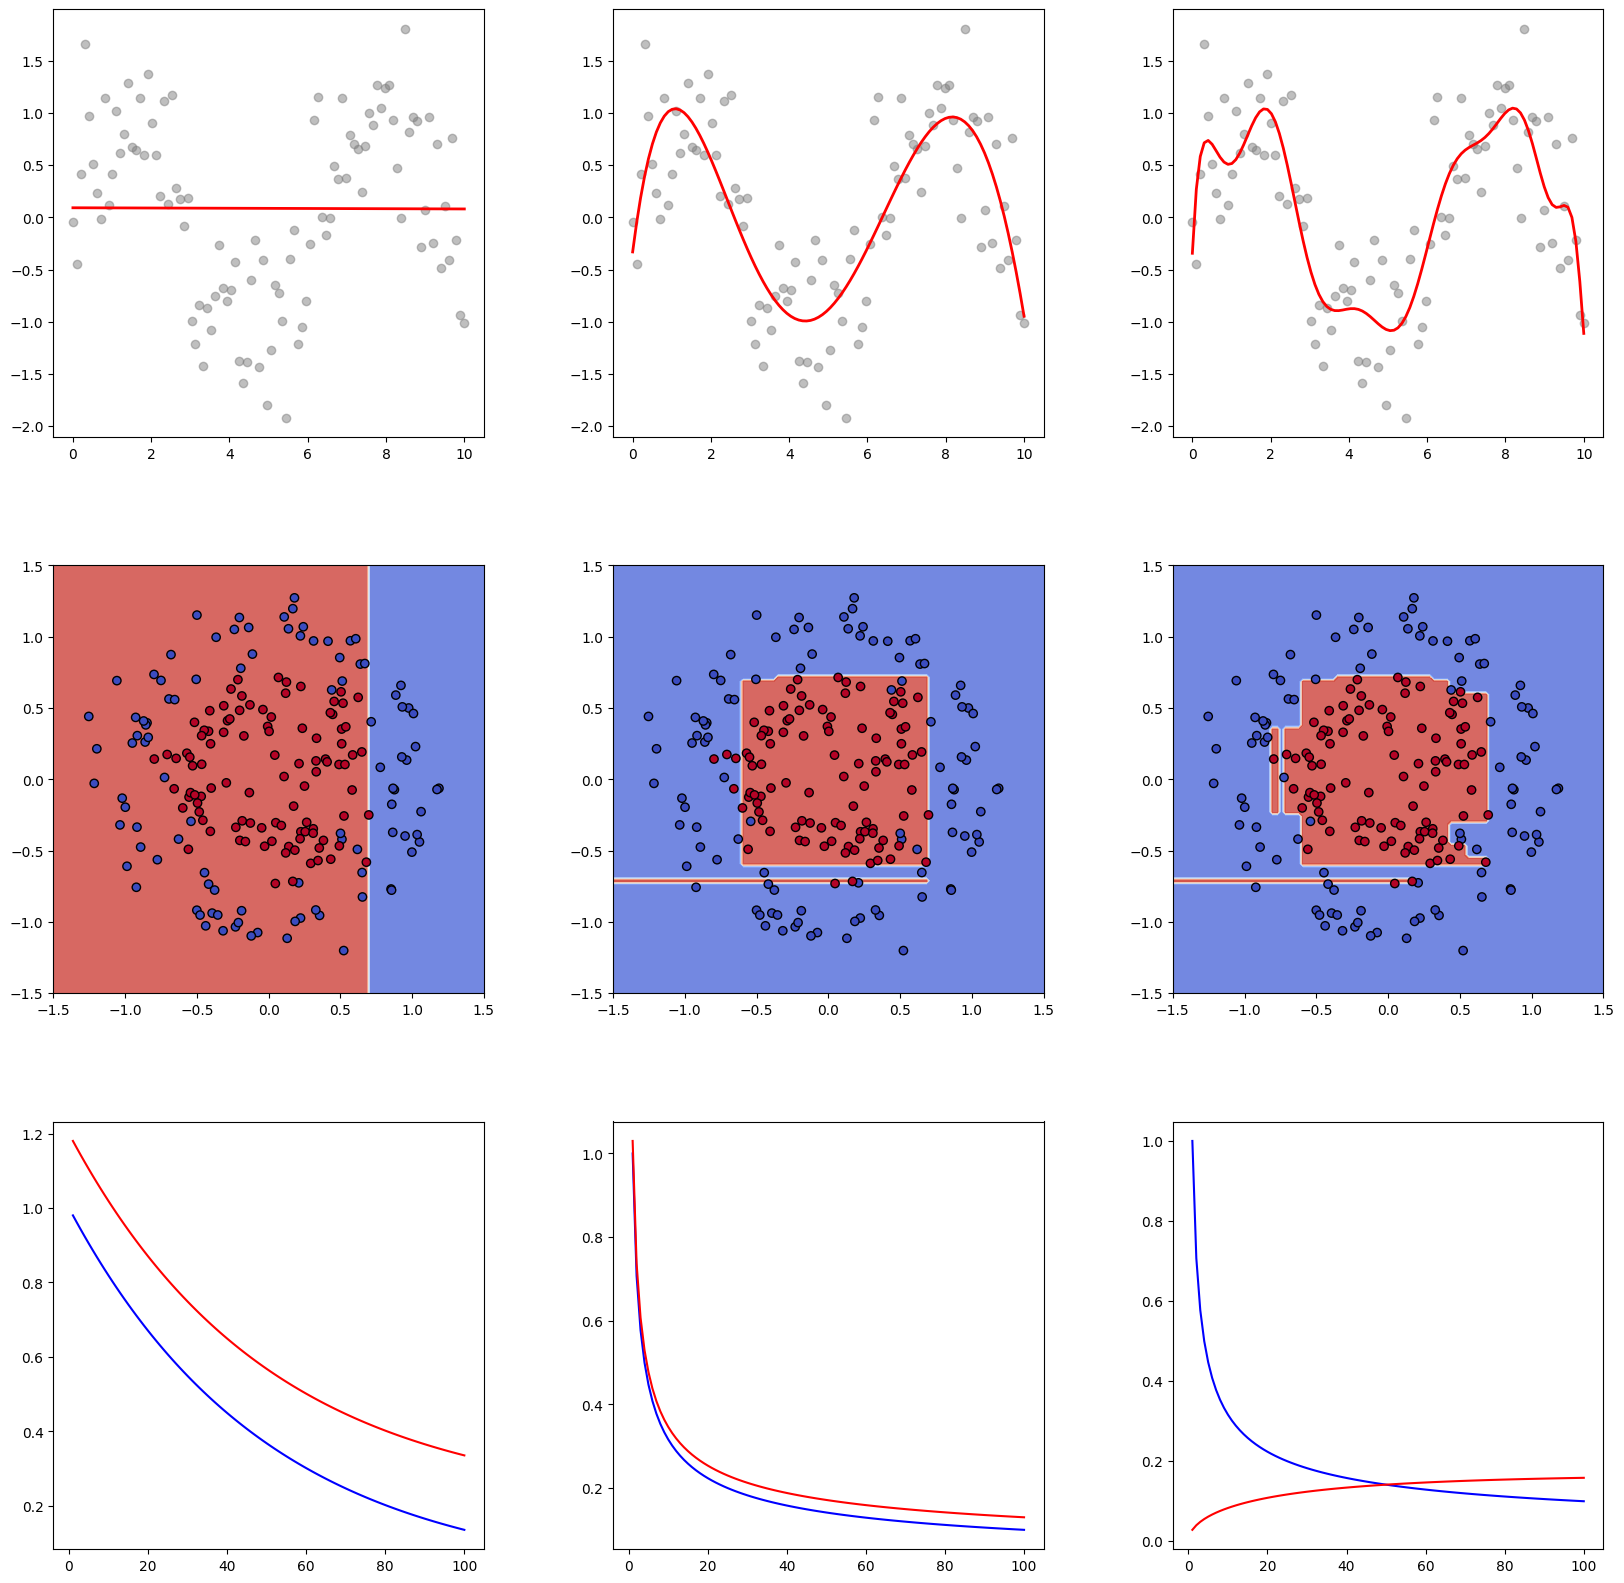

In [9]:
from sklearn.datasets import make_circles
from sklearn.tree import DecisionTreeClassifier

# Set up the overall figure
fig = plt.figure(figsize=(20, 20), dpi=100)

# Titles for rows and columns
row_titles = ['Regression', 'Classification', 'Deep Learning']
col_titles = ['Underfitting', 'Just Right', 'Overfitting']

# Create main grid for plots
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
axes = [[fig.add_subplot(gs[i, j]) for j in range(3)] for i in range(3)]

# First row: Regression
x = np.linspace(0, 10, 100)
y = np.sin(x) + np.random.normal(0, 0.5, 100)
degrees = [1, 5, 15]

for i in range(3):
    p = np.poly1d(np.polyfit(x, y, degrees[i]))
    axes[0][i].scatter(x, y, color='gray', alpha=0.5)
    axes[0][i].plot(x, p(x), color='red', linewidth=2)

# Second row: Classification
X_vis, y_vis = make_circles(n_samples=200, factor=0.5, noise=0.15, random_state=42)
classifiers = [
    DecisionTreeClassifier(max_depth=1, random_state=42),
    DecisionTreeClassifier(max_depth=5, random_state=42),
    DecisionTreeClassifier(max_depth=None, random_state=42)
]
for i in range(3):
    clf_vis = classifiers[i]
    clf_vis.fit(X_vis, y_vis)
    xx, yy = np.meshgrid(np.linspace(-1.5, 1.5, 100), np.linspace(-1.5, 1.5, 100))
    Z = clf_vis.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    axes[1][i].contourf(xx, yy, Z, alpha=0.8, cmap='coolwarm')
    axes[1][i].scatter(X_vis[:, 0], X_vis[:, 1], c=y_vis, cmap='coolwarm', edgecolors='k')

# Third row: Error Trends
epochs = np.linspace(1, 100, 100)
errors = [
    (np.exp(-epochs / 50), np.exp(-epochs / 50) + 0.2),
    (1 / np.sqrt(epochs), 1 / np.sqrt(epochs) + 0.03),
    (1 / np.sqrt(epochs), 1 / np.sqrt(epochs) * np.log2(1 + epochs / 50))
]
for i in range(3):
    train_err, val_err = errors[i]
    axes[2][i].plot(epochs, train_err, label='Training Error', color='blue')
    axes[2][i].plot(epochs, val_err, label='Validation Error', color='red')

for i in range(3):
    for j in range(3):
        ax = axes[i][j]
        _ = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())

plt.show()

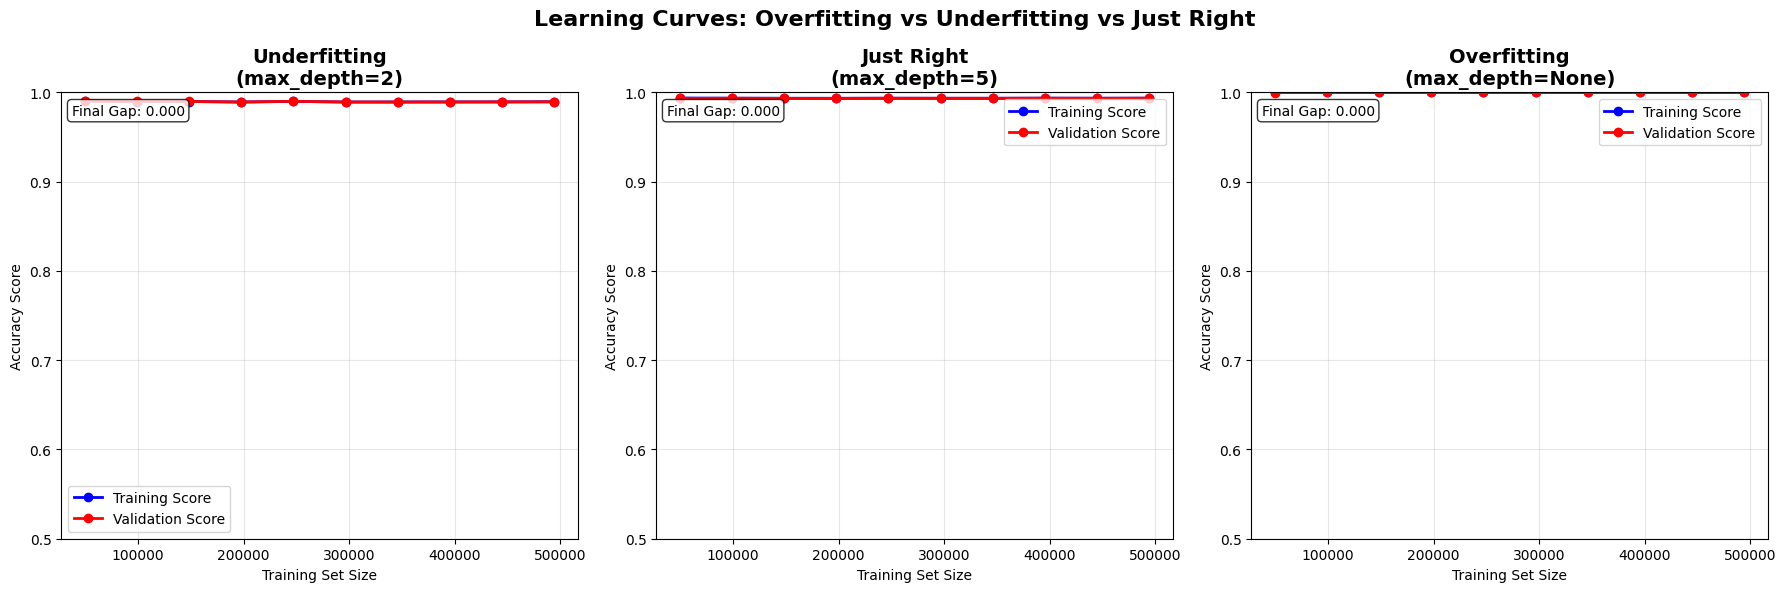

Learning Curve Interpretation Guide:
• Underfitting: Both training and validation scores are low and converge
• Just Right: High validation score with small gap to training score
• Overfitting: Large gap between training and validation scores

Solutions:
• Underfitting: Increase model complexity, add features, reduce regularization
• Overfitting: Reduce complexity, add regularization, get more data


In [10]:
# Demonstrate overfitting vs underfitting vs just right
# We'll use Random Forest with different complexity levels

from sklearn.model_selection import learning_curve  # Added import

# Define models with different complexity as pipelines
complexity_models = {
    'Underfitting\n(max_depth=2)': Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("clf", RandomForestClassifier(n_estimators=10, max_depth=2, random_state=42))
    ]),
    'Just Right\n(max_depth=5)': Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("clf", RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42))
    ]),
    'Overfitting\n(max_depth=None)': Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("clf", RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=42))
    ])
}

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, (name, model) in enumerate(complexity_models.items()):
    # Generate learning curves
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_train, y_train, cv=5,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='accuracy', n_jobs=-1
    )
    
    # Calculate means and standard deviations
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    # Plot learning curves
    axes[i].plot(train_sizes, train_mean, 'o-', color='blue', 
                label='Training Score', linewidth=2, markersize=6)
    axes[i].fill_between(train_sizes, train_mean - train_std,
                        train_mean + train_std, alpha=0.1, color='blue')
    
    axes[i].plot(train_sizes, val_mean, 'o-', color='red', 
                label='Validation Score', linewidth=2, markersize=6)
    axes[i].fill_between(train_sizes, val_mean - val_std,
                        val_mean + val_std, alpha=0.1, color='red')
    
    axes[i].set_xlabel('Training Set Size')
    axes[i].set_ylabel('Accuracy Score')
    axes[i].set_title(name, fontsize=14, fontweight='bold')
    axes[i].legend()
    axes[i].grid(alpha=0.3)
    axes[i].set_ylim(0.5, 1.0)
    
    # Add gap annotation
    final_gap = train_mean[-1] - val_mean[-1]
    axes[i].text(0.02, 0.95, f'Final Gap: {final_gap:.3f}', 
                transform=axes[i].transAxes,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                fontsize=10)

plt.suptitle('Learning Curves: Overfitting vs Underfitting vs Just Right', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Interpretation guide
print("Learning Curve Interpretation Guide:")
print("=" * 50)
print("• Underfitting: Both training and validation scores are low and converge")
print("• Just Right: High validation score with small gap to training score")
print("• Overfitting: Large gap between training and validation scores")
print("\nSolutions:")
print("• Underfitting: Increase model complexity, add features, reduce regularization")
print("• Overfitting: Reduce complexity, add regularization, get more data")

## 7. Validation Curves for Hyperparameter Analysis

Validation curves help us understand how individual hyperparameters affect model performance.

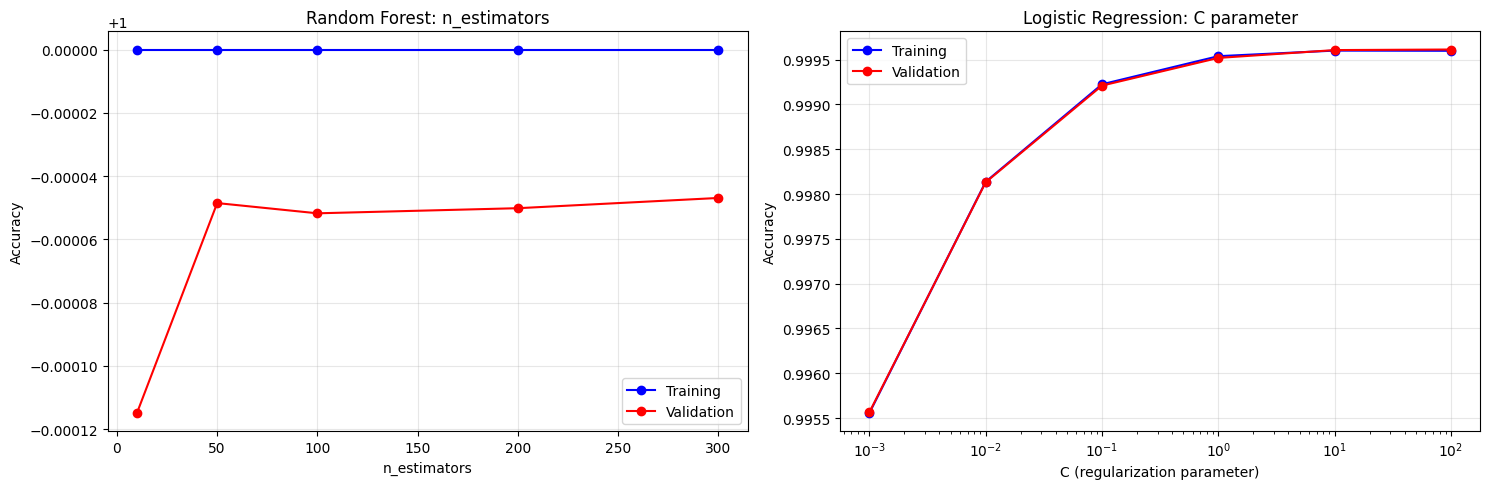

In [11]:
# Analyze the effect of different hyperparameters
from sklearn.model_selection import validation_curve

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 1. Random Forest: n_estimators
param_range_rf = [10, 50, 100, 200, 300]
train_scores_rf, val_scores_rf = validation_curve(
    trained_models['Random Forest'], X_train, y_train,
    param_name='clf__n_estimators', param_range=param_range_rf,
    cv=3, scoring='accuracy', n_jobs=-1
)

train_mean_rf = np.mean(train_scores_rf, axis=1)
val_mean_rf = np.mean(val_scores_rf, axis=1)

axes[0].plot(param_range_rf, train_mean_rf, 'o-', color='blue', label='Training')
axes[0].plot(param_range_rf, val_mean_rf, 'o-', color='red', label='Validation')
axes[0].set_xlabel('n_estimators')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Random Forest: n_estimators')
axes[0].legend()
axes[0].grid(alpha=0.3)

# 2. Logistic Regression: C parameter
param_range_lr = np.logspace(-3, 2, 6)
train_scores_lr, val_scores_lr = validation_curve(
    trained_models['Logistic Regression'], X_train, y_train,
    param_name='clf__C', param_range=param_range_lr,
    cv=3, scoring='accuracy', n_jobs=-1
)

train_mean_lr = np.mean(train_scores_lr, axis=1)
val_mean_lr = np.mean(val_scores_lr, axis=1)

axes[1].semilogx(param_range_lr, train_mean_lr, 'o-', color='blue', label='Training')
axes[1].semilogx(param_range_lr, val_mean_lr, 'o-', color='red', label='Validation')
axes[1].set_xlabel('C (regularization parameter)')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Logistic Regression: C parameter')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Benchmarking Against Baselines

It's important to compare your models against simple baselines to ensure they're actually learning something meaningful.

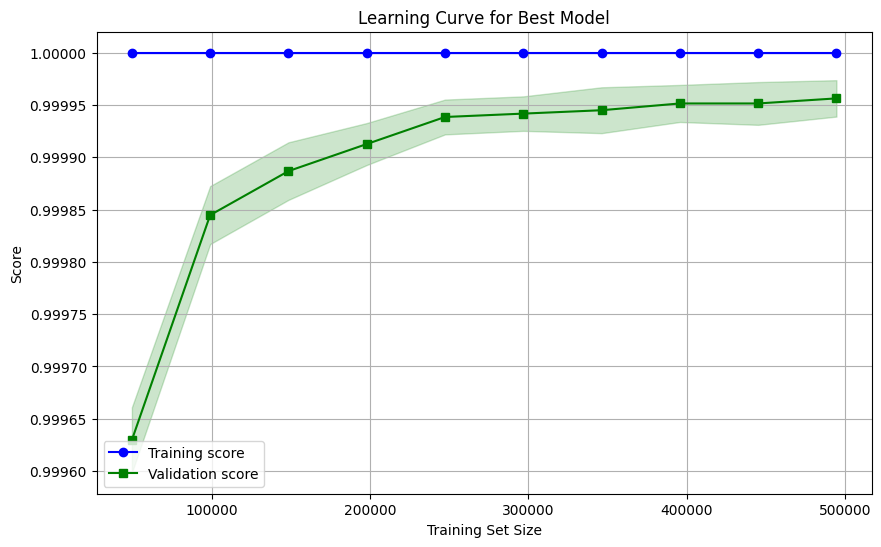

In [12]:
# Plot learning curve for the best model for better visibility
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# Ensure best_model is defined, fallback to a reasonable default pipeline if not
if 'best_model' not in locals():
    best_model = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("clf", RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42))
    ])
    best_model.fit(X_train, y_train)

train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_train, y_train, cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='accuracy', n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training score', color='blue', marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
plt.plot(train_sizes, val_mean, label='Validation score', color='green', marker='s')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='green', alpha=0.2)
plt.title('Learning Curve for Best Model')
plt.xlabel('Training Set Size')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()
plt.show()

## Summary

In this comprehensive model evaluation notebook, we covered:

### Key Evaluation Techniques:

1. **Classification Metrics**: Understanding accuracy, precision, recall, and F1-score
2. **Confusion Matrix Analysis**: Detailed breakdown of prediction errors
3. **ROC Curves and AUC**: Evaluating binary classification performance
4. **Precision-Recall Curves**: Especially important for imbalanced datasets
5. **Overfitting Detection**: Using learning curves and validation curves
6. **Baseline Comparison**: Ensuring models perform better than simple baselines
7. **Comprehensive Reporting**: Creating actionable evaluation reports

### Key Insights:

- **Metric Selection**: Choose metrics appropriate for your problem (F1-score for imbalanced data)
- **Multiple Perspectives**: Use various evaluation methods to get a complete picture
- **Overfitting Vigilance**: Always check training vs validation performance
- **Baseline Importance**: Simple baselines help validate that models are learning
- **Class Imbalance**: Special attention needed for imbalanced datasets common in metabolomics

### Best Practices:

- Always use a held-out test set for final evaluation
- Consider multiple metrics, not just accuracy
- Visualize performance with curves and matrices
- Compare against reasonable baselines
- Document findings in comprehensive reports
- Consider the business/scientific context when interpreting results

### Next Steps:

In the final notebook, we'll explore **Model Interpretability**, learning how to:
- Extract and visualize feature importance
- Use SHAP values for explanation
- Create interpretable visualizations
- Understand model decision-making processes

These evaluation techniques form the foundation for responsible machine learning in metabolomics research.